In [ ]:
  !pip install opencv-python numpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 2492 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
198551472/198551472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 884s 11s/step - accuracy: 0.5897 - loss: 1.0470 - val_accuracy: 0.7500 - val_loss: 0.8297 - learning_rate: 0.0010
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.8139 - loss: 0.5000 - val_accuracy: 0.7361 - val_loss: 0.8417 - learning_rate: 0.0010
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.8745 - loss: 0.3312 - val_accuracy: 0.7778 - val_loss: 0.7072 - learning_rate: 0.0010
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.9095 - loss: 0.2495 - val_accuracy: 0.8889 - val_loss: 0.5523 - learning_rate: 0.0010
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9055 - loss: 0.2811 - val_accuracy: 0.8056 - val_loss: 0.6635 - learning_rate: 0.0010
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.947

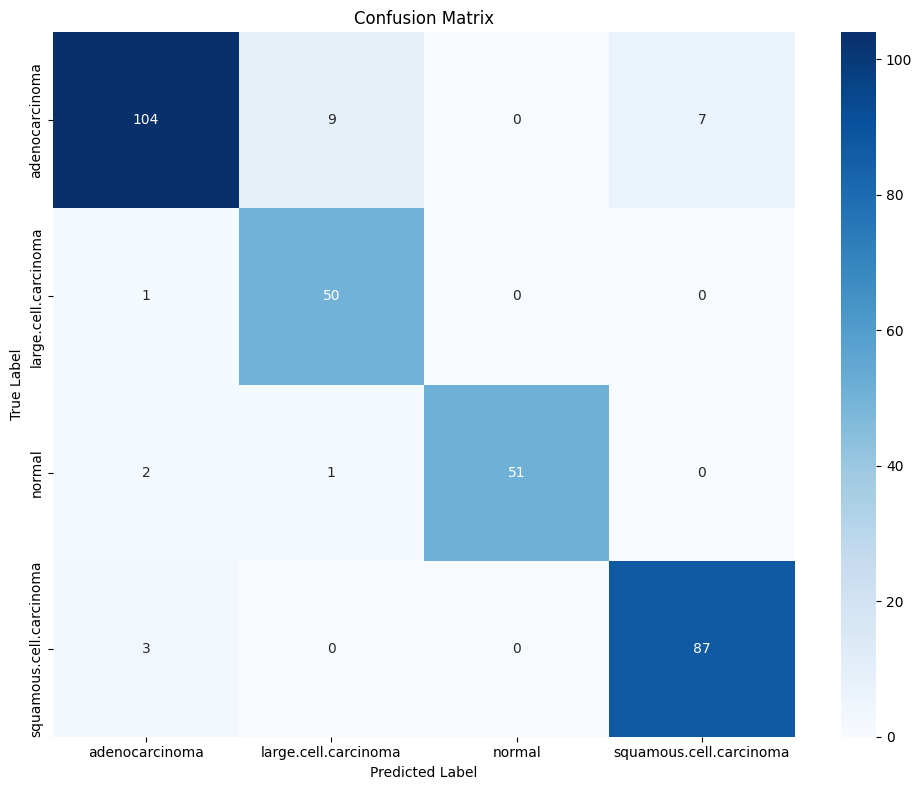

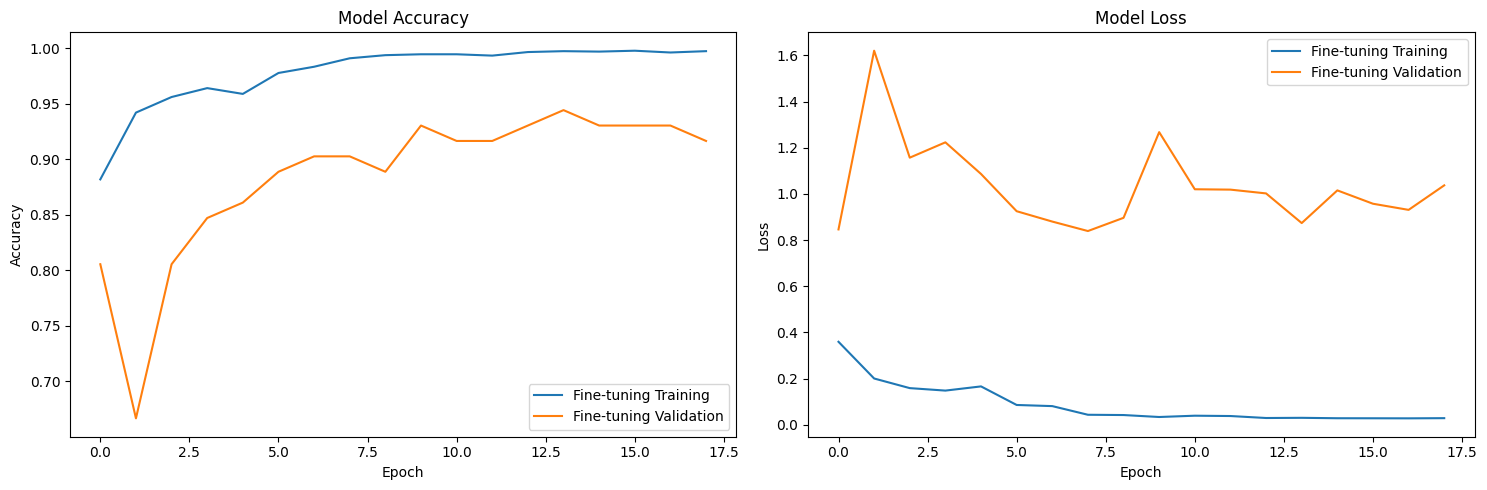

Model saved successfully!


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from tensorflow.keras.applications import ConvNeXtSmall
from tensorflow.keras.applications.convnext import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

# Suppress warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

class LungCancerClassificationConfig:
    """Configuration class for the lung cancer classification model"""
    # Paths (adjust as needed)
    TRAIN_DIR = "/content/drive/My Drive/Lungcancer.Dataset.Augmented/train"
    VALID_DIR = "/content/drive/My Drive/Lungcancer.Dataset.Augmented/valid"
    TEST_DIR = "/content/drive/My Drive/Lungcancer.Dataset.Augmented/test"

    # Model Hyperparameters
    IMG_SIZE = (224,224)
    BATCH_SIZE = 32
    INITIAL_LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-5
    DROPOUT_RATE = 0.5

class LungCancerClassifier:
    def __init__(self, config=LungCancerClassificationConfig):
        self.config = config
        self.class_names = None
        self.num_classes = None

    def create_advanced_data_generators(self):
        """
        Create sophisticated data generators with medical-aware augmentations
        """
        train_datagen = ImageDataGenerator(
            preprocessing_function=preprocess_input,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            brightness_range=[0.8, 1.2],
            horizontal_flip=True,
            vertical_flip=False,  # Typically not used in medical imaging
            fill_mode='constant',
            cval=0
        )

        valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
        test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

        # Load data generators
        train_generator = train_datagen.flow_from_directory(
            self.config.TRAIN_DIR,
            target_size=self.config.IMG_SIZE,
            batch_size=self.config.BATCH_SIZE,
            class_mode='categorical',
            shuffle=True
        )

        valid_generator = valid_datagen.flow_from_directory(
            self.config.VALID_DIR,
            target_size=self.config.IMG_SIZE,
            batch_size=self.config.BATCH_SIZE,
            class_mode='categorical',
            shuffle=False
        )

        test_generator = test_datagen.flow_from_directory(
            self.config.TEST_DIR,
            target_size=self.config.IMG_SIZE,
            batch_size=self.config.BATCH_SIZE,
            class_mode='categorical',
            shuffle=False
        )

        # Store class information
        self.class_names = list(train_generator.class_indices.keys())
        self.num_classes = len(self.class_names)

        return train_generator, valid_generator, test_generator

    def create_advanced_model(self):
        """
        Create a robust ConvNeXt-based classification model
        """
        # Base ConvNeXt model
        base_model = ConvNeXtSmall(
            weights='imagenet',
            include_top=False,
            input_shape=(*self.config.IMG_SIZE, 3)
        )
        base_model.trainable = False

        # Advanced model architecture
        inputs = Input(shape=(*self.config.IMG_SIZE, 3))
        x = base_model(inputs, training=False)
        x = GlobalAveragePooling2D()(x)
        x = BatchNormalization()(x)

        # Multiple dense layers with advanced regularization
        x = Dense(
            1024,
            activation='swish',
            kernel_regularizer=l2(self.config.WEIGHT_DECAY)
        )(x)
        x = Dropout(self.config.DROPOUT_RATE)(x)

        x = Dense(
            512,
            activation='swish',
            kernel_regularizer=l2(self.config.WEIGHT_DECAY)
        )(x)
        x = Dropout(self.config.DROPOUT_RATE)(x)

        outputs = Dense(
            self.num_classes,
            activation='softmax'
        )(x)

        model = Model(inputs=inputs, outputs=outputs)
        return model, base_model

    def train_model(self, model, train_generator, valid_generator):
        """
        Advanced training with sophisticated callbacks
        """
        # Compute class weights
        class_weights = class_weight.compute_class_weight(
            'balanced',
            classes=np.unique(train_generator.classes),
            y=train_generator.classes
        )
        class_weights = dict(enumerate(class_weights))

        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )

        model_checkpoint = ModelCheckpoint(
            'best_lung_cancer_model.keras',
            monitor='val_accuracy',
            save_best_only=True
        )

        # Compile model
        model.compile(
            optimizer=AdamW(
                learning_rate=self.config.INITIAL_LEARNING_RATE,
                weight_decay=self.config.WEIGHT_DECAY
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Training
        history = model.fit(
            train_generator,
            validation_data=valid_generator,
            epochs=30,
            class_weight=class_weights,
            callbacks=[early_stopping, reduce_lr, model_checkpoint]
        )

        return history

    def evaluate_model(self, model, test_generator):
        """
        Comprehensive model evaluation
        """
        # Evaluate
        test_loss, test_acc = model.evaluate(test_generator)
        print(f"\nTest Accuracy: {test_acc:.2%}")

        # Predictions
        predictions = model.predict(test_generator)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = test_generator.classes

        # Classification Report
        print("\nClassification Report:")
        print(classification_report(
            true_classes,
            predicted_classes,
            target_names=self.class_names
        ))

        # Confusion Matrix
        cm = confusion_matrix(true_classes, predicted_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=self.class_names,
            yticklabels=self.class_names
        )
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

    def run_experiment(self):
        """
        Main experiment pipeline
        """
        # Data generators
        train_generator, valid_generator, test_generator = self.create_advanced_data_generators()

        # Create model
        model, base_model = self.create_advanced_model()

        # First phase: Train top layers
        base_model.trainable = False
        history = self.train_model(model, train_generator, valid_generator)

        # Second phase: Fine-tune some base model layers
        for layer in base_model.layers[-50:]:
            layer.trainable = True

        # Recompile and continue training
        model.compile(
            optimizer=AdamW(
                learning_rate=1e-6,
                weight_decay=self.config.WEIGHT_DECAY
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        fine_tune_history = self.train_model(model, train_generator, valid_generator)

        # Final evaluation
        self.evaluate_model(model, test_generator)

        # Visualization
        self.plot_training_history(history, fine_tune_history)

        # Save final model
        model.save('final_lung_cancer_model.h5')
        print("Model saved successfully!")

    def plot_training_history(self, initial_history, fine_tune_history):
        """
        Visualize training and validation metrics
        """
        plt.figure(figsize=(15, 5))

        # Accuracy Plot
        plt.subplot(1, 2, 1)
        # plt.plot(initial_history.history['accuracy'], label='Initial Training')
        # plt.plot(initial_history.history['val_accuracy'], label='Initial Validation')
        plt.plot(fine_tune_history.history['accuracy'], label='Fine-tuning Training')
        plt.plot(fine_tune_history.history['val_accuracy'], label='Fine-tuning Validation')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()

        # Loss Plot
        plt.subplot(1, 2, 2)
        # plt.plot(initial_history.history['loss'], label='Initial Training')
        # plt.plot(initial_history.history['val_loss'], label='Initial Validation')
        plt.plot(fine_tune_history.history['loss'], label='Fine-tuning Training')
        plt.plot(fine_tune_history.history['val_loss'], label='Fine-tuning Validation')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()

        plt.tight_layout()
        plt.show()

def main():
    classifier = LungCancerClassifier()
    classifier.run_experiment()

if __name__ == '__main__':
    main()